# Equity Derivatives Homework 2: Group 8
## Teammates: Simeon Bikorimana, Rui Jiang, Vismayie Vandanapu

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_1samp
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import minimize
%matplotlib inline

### Problem 1(a)

In [2]:
NDX = pd.read_csv('HW2_data.csv', nrows=4, usecols=[0, 1], header=None, index_col=0).T
NDX

,NDX Index,Interest,Forward,Tenor
1,5448,1.25%,5460,349


Since the NDX Index is 5448, based on the data trading data, strikes ATM at 5450, which is the closest strike price to 5448 with trading data. And it has 5% OTM at $ 5448*(1+5\%) = 5720.4$, so we choose 5700, the closest strike price to 5720.4 with trading data.

So we long the call at 5450, and short the call at 5700, the market price of the $\textbf{5% call spread}$ is: $ 337.1 - 194.8 = 142.3$

Similarly, for 5% OTM for put spread, it strikes at $ 5448*(1-5\%) = 5175.6$, so we choose the strike at 5200, the closest strike price to 5175.6 with trading data.

So we long the put at 5450, and short the put at 5200, the market price of the $\textbf{5% put spread}$ is: $ 326.1 - 221.3 = 104.8$.

### Problem 1(b)

Implement Black-Scholes Model for Price and Greeks

In [3]:
""" # The Black Scholes Formula
# CallPutFlag - This is set to 'c' for call option, anything else for put
# S - Stock price
# K - Strike price
# T - Time to maturity
# r - Riskfree interest rate
# d - Dividend yield
# v - Volatility
"""

from scipy.stats import norm
from math import *
def BlackScholes(CallPutFlag,S,K,T,r,d,v):
    d1 = (log(float(S)/K)+((r-d)+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if CallPutFlag=='c':
        return S*exp(-d*T)*norm.cdf(d1)-K*exp(-r*T)*norm.cdf(d2)
    else:
        return K*exp(-r*T)*norm.cdf(-d2)-S*exp(-d*T)*norm.cdf(-d1)

In [4]:
"""
Calculating the partial derivatives for a Black Scholes Option (Call)
# S - Stock price
# K - Strike price
# T - Time to maturity
# r - Riskfree interest rate
# d - Dividend yield
# v - Volatility
Return:
Delta: partial wrt S
Gamma: second partial wrt S
Theta: partial wrt T
Vega: partial wrt v
Rho: partial wrt r 
"""

from scipy.stats import norm
from math import *
def Black_Scholes_Greeks_Call(S, K, r, v, T, d):
    T_sqrt = sqrt(T)
    d1 = (log(float(S)/K)+((r-d)+v*v/2.)*T)/(v*T_sqrt)
    d2 = d1-v*T_sqrt
    Delta = norm.cdf(d1)
    Gamma = norm.pdf(d1)/(S*v*T_sqrt)
    Theta =- (S*v*norm.pdf(d1))/(2*T_sqrt) - r*K*exp( -r*T)*norm.cdf(d2)
    Vega = S * T_sqrt*norm.pdf(d1)
    Rho = K*T*exp(-r*T)*norm.cdf(d2)
    return Delta, Gamma, Theta, Vega, Rho

In [5]:
"""
Calculating the partial derivatives for a Black Scholes Option (Put)
# S - Stock price
# K - Strike price
# T - Time to maturity
# r - Riskfree interest rate
# d - Dividend yield
# v - Volatility
Return:
Delta: partial wrt S
Gamma: second partial wrt S
Theta: partial wrt T
Vega: partial wrt v
Rho: partial wrt r 
"""

from scipy.stats import norm
from math import *
def Black_Scholes_Greeks_Put(S, K, r, v, T, d):
    """
    Calculate partial derivatives for a Black Scholes Option (Put) 
    """ 
    T_sqrt = sqrt(T)
    d1 = (log(float(S)/K)+r*T)/(v*T_sqrt) + 0.5*v*T_sqrt
    d2 = d1-(v*T_sqrt)
    Delta = -norm.cdf(-d1)
    Gamma = norm.pdf(d1)/(S*v*T_sqrt)
    Theta = -(S*v*norm.pdf(d1)) / (2*T_sqrt)+ r*K * exp(-r*T) * norm.cdf(-d2)
    Vega = S * T_sqrt * norm.pdf(d1)
    Rho = -K*T*exp(-r*T) * norm.cdf(-d2)
    return Delta, Gamma, Theta, Vega, Rho

Set up parameters

In [5]:
S = 5448
K0 = 5450
K_callspread = 5700
K_putspread = 5200
r = np.log(1+0.0125)
d = 0
T = 349./365.

Reformat data

In [6]:
def p2f(x):
    return float(x.strip('%'))/100
data_call = pd.read_csv('HW2_data.csv', skiprows = 5, usecols = [0, 1, 2, 3, 4, 5], converters = {'Implied Vol. %': p2f})
data_put = pd.read_csv('HW2_data.csv', skiprows = 5, usecols = [6, 7, 8, 9, 10, 11], converters = {'Implied Vol. %.1': p2f})
print(data_call.head() )
print(data_put.head() )

   Strike  C     Bid     Ask      Mid  Implied Vol. %
0    2700  C  2719.2  2738.9  2729.05           0.291
1    2800  C  2621.6  2641.1  2631.35           0.290
2    2900  C  2524.1  2543.6  2533.85           0.287
3    3000  C  2427.0  2446.2  2436.60           0.285
4    3100  C  2329.6  2349.1  2339.35           0.279
   Strike.1  P  Bid.1  Ask.1  Mid.1  Implied Vol. %.1
0      2700  P    3.0    6.4   4.70             0.318
1      2800  P    3.0    7.4   5.20             0.307
2      2900  P    5.0    8.6   6.80             0.303
3      3000  P    6.0    9.9   7.95             0.295
4      3100  P    8.0   11.4   9.70             0.289


Black-Scholes for call spread

In [7]:
print('Market Price: 337.1')
print('Call Spread BS Price: ', BlackScholes('c', S, K0, T, r, d, 0.154))

Market Price: 337.1
Call Spread BS Price:  357.23452397518804


Since we have quite different call spread price for Black-Scholes, we are going to examine the impact of implied dividend.

In [8]:
def call_dividend(d0):
    return (BlackScholes('c', S, data_call['Strike'][i], T, r, d0, data_call['Implied Vol. %'][i])-data_call['Mid'][i])
d_call = []
for i in range(data_call.shape[0]):
    d_call.append(brentq(call_dividend, -10, 10))

Text(0.5,1,'Implied Dividend')

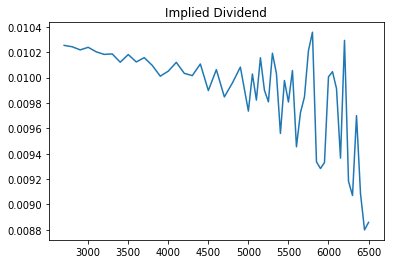

In [9]:
plt.plot(data_call['Strike'], d_call)
plt.title('Implied Dividend')

Based on the graph above, we just set up the dividend as 0.01, and we are going to calculate the implied volatility based on the dividend.

In [10]:
def call_sigma(v):
    return (BlackScholes('c', S, K0, T, r, 0.01, v) - BlackScholes('c', S, K_callspread, T, r, 0.01, v) - 142.3)
brentq(call_sigma, -0.5, 0.5) 

-1.57560924762628e-12

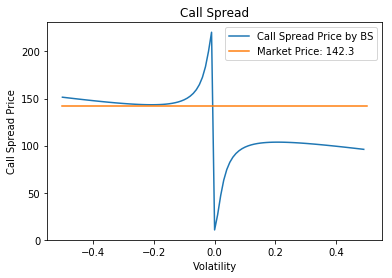

In [11]:
plt.plot(np.arange(-0.5, 0.5, 0.01), [BlackScholes('c', S, K0, T, r, 0.01, v) - BlackScholes('c', S, K_callspread, T, r, 0.01, v) for v in np.arange(-0.5, 0.5, 0.01)])
plt.plot([-0.5, 0.5], [142.3, 142.3], '-')
plt.xlabel('Volatility')
plt.ylabel('Call Spread Price')
plt.title('Call Spread')
plt.legend(['Call Spread Price by BS', 'Market Price: 142.3'])

For the graph above, we can see that we even do not have positive volatility.

Black-Scholes for put spread

In [12]:
print('BS Price For Put: ', BlackScholes('p', S, K0, T, r, d, 0.154))
print('Market Price: 326.1')

BS Price For Put:  294.88252326345446
Market Price: 326.1


Similarly, since we have quite different put spread price for Black-Scholes, we are going to examine the impact of implied dividend.

In [13]:
def put_dividend(d0):
    return (BlackScholes('p', S, data_put['Strike.1'][i], T, r, d0, data_put['Implied Vol. %.1'][i])-data_put['Mid.1'][i])
d_put = []
for i in range(data_put.shape[0]):
    d_put.append(brentq(put_dividend, -10, 10))

Text(0.5,1,'Implied Dividend')

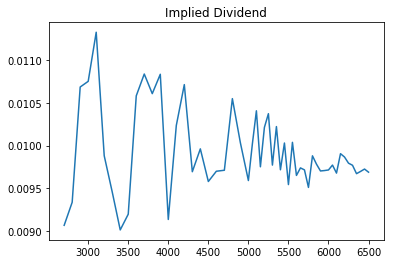

In [14]:
plt.plot(data_put['Strike.1'], d_put)
plt.title('Implied Dividend')

We now set up dividend as 0.01 as well, and we are going to calculate the implied volatility.

In [15]:
def put_sigma(v):
    return (BlackScholes('p', S, K0, T, r, 0.01, v) - BlackScholes('p', S, K_putspread, T, r, 0.01, v) - 104.8)
print(brentq(put_sigma, -0.5, 0.5))
print(brentq(put_sigma, 0, 0.5))

-0.49727538933014925
0.10561822791540872


c:\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


The implied volatilities have a positive solution, but quite different from the given data.

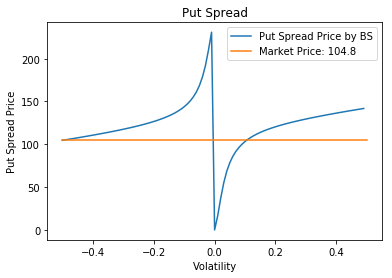

In [16]:
plt.plot(np.arange(-0.5, 0.5, 0.01), [BlackScholes('p', S, K0, T, r, 0.01, v) - BlackScholes('p', S, K_putspread, T, r, 0.01, v) for v in np.arange(-0.5, 0.5, 0.01)])
plt.plot([-0.5, 0.5], [104.8, 104.8], '-')
plt.xlabel('Volatility')
plt.ylabel('Put Spread Price')
plt.title('Put Spread')
plt.legend(['Put Spread Price by BS', 'Market Price: 104.8'])

The two graphs above reveal that call and put spread prices from the Black-Scholes Model are quite different from the market prices respectively. Because we obtain the prices from the bid prices and the ask prices, we could always get different volatilities and dividends, which leads to larger spreads. Hence, the bid-ask spread results in the wrong estimation for our Black-Scholes Model to evaluate the market prices of spreads.

### Problem 2(a)

We compare the parameter Volatility for SVI with the implied volatility. In order to calibrate the SVI model, we modified SVI volatility function to be $\sigma^{*2}_{SVI}(k_F, T) = a + b(\rho(\ln{k_F}- m) + \sqrt{(\ln{k_F} - m)^2 + s^2})$

In [17]:
def SVI_vol_diff(sigma, K, F, a, b, rho, m, s):
    k_F = K/F  #forward moneyness
    vol_SVI = (a + b * (rho * (np.log(k_F) - m) + np.sqrt((np.log(k_F) - m)**2 + s**2)))
    return sum(np.abs(vol_SVI - sigma**2))

def SVI(K, F, a, b, rho, m, s):
    k_F = K/F
    return np.sqrt(a + b * (rho * (np.log(k_F) - m) + np.sqrt((np.log(k_F) - m)**2 + s**2)))

In [18]:
variables = minimize(lambda variables: SVI_vol_diff(data_call['Implied Vol. %'], data_call['Strike'], 5460, *variables), np.zeros(5), 
                  constraints = ({'type': 'ineq', 'fun': lambda x: x[2]}, {'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'ineq', 'fun': lambda x: 0.25 - x[1] * (1 + x[2])}))
variables

     fun: 0.03149470610249917
     jac: array([ 0.        , -0.47273   ,  0.07841603, -0.08616914,  0.06641084])
 message: 'Optimization terminated successfully.'
    nfev: 289
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([9.16431340e-19, 1.19752747e-01, 1.48354693e-01, 1.95977900e-01,
       1.14423552e-01])

In [19]:
variables = variables.x

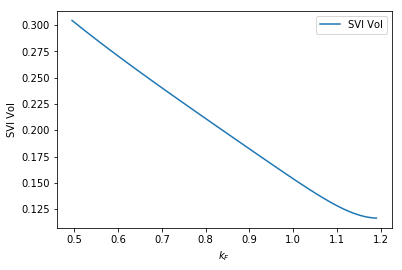

In [26]:
plt.plot(data_call['Strike']/5460, SVI(data_call['Strike'], 5460, *variables), label='SVI Vol')
plt.xlabel('$k_F$')
plt.ylabel('SVI Vol')
plt.title('Sensitivty of SVI_vol with Forward moneyness')
plt.show()

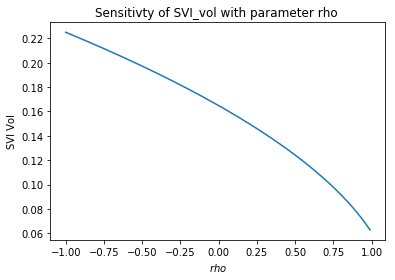

In [38]:
## checking sensitivity of volatility to parameter a assuming the strike is 5460

a = variables[0]
b=variables[1]
rho = variables[2]
m=variables[3]
s=variables[4]
K=5460
F=5460
rho_range = np.arange(-1.0,1.0,0.01)
svi_rho = []

for i in range (0,len(rho_range)):
    svi_temp = SVI(K, F, a, b, rho_range[i], m, s)
    svi_rho.append(svi_temp)
    
plt.plot(rho_range, svi_rho)
plt.xlabel('$rho$')
plt.ylabel('SVI Vol')
plt.title('Sensitivty of SVI_vol with parameter rho ')
plt.show()

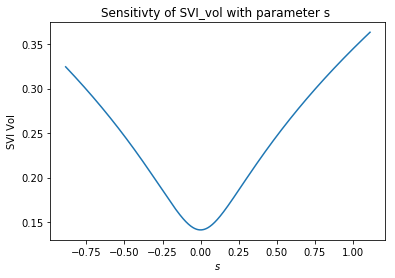

In [36]:
## checking sensitivity of volatility to parameter s assuming the strike is 5460

a = variables[0]
b=variables[1]
rho = variables[2]
m=variables[3]
s=variables[4]
K=5460
F=5460
s_range = np.arange(0.114-1,0.114+1,0.001)
svi_s = []

for i in range (0,len(s_range)):
    svi_temp = SVI(K, F, a, b, rho, m, s_range[i])
    svi_s.append(svi_temp)
    
plt.plot(s_range, svi_s)
plt.xlabel('$ s $')
plt.ylabel('SVI Vol')
plt.title('Sensitivty of SVI_vol with parameter s ')
plt.show()

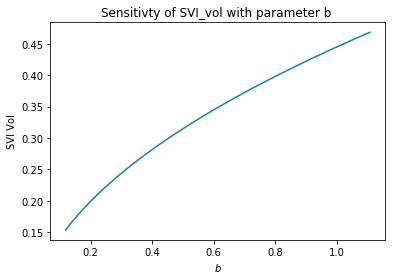

In [45]:
## checking sensitivity of volatility to parameter b assuming the strike is 5460

a = variables[0]
b=variables[1]
rho = variables[2]
m=variables[3]
s=variables[4]
K=5460
F=5460
b_range = np.arange(0.119,0.119+1,0.01)
svi_b = []

for i in range (0,len(b_range)):
    svi_temp = SVI(K, F, a, b_range[i], rho, m, s)
    svi_b.append(svi_temp)
    
plt.plot(b_range, svi_b)
plt.xlabel('$ b $')
plt.ylabel('SVI Vol')
plt.title('Sensitivty of SVI_vol with parameter b ')
plt.show()

### Problem 2(b)

( i )

In [22]:
def BlackScholes_Digital_call(S,K,T,r,d,v):
    d2 = (log(float(S)/K)+((r-d)-v*v/2.)*T)/(v*sqrt(T))    
#     d2 = (np.log(S/K)+(r-q-vol**2/2)*T)/(vol*np.sqrt(T))
    return np.exp(-r*T)*norm.cdf(d2)

In [23]:
print('The price of the digital call by Black-Scholes is:', BlackScholes_Digital_call(5450,5450,T,r,0.01,0.154))

The price of the digital call by Black-Scholes is: 0.4704912914653554


( i i )

For 1% call spread, according to the question, we will long at $C((1 - 1\%)K) / \epsilon$ and short at $C(K)/\epsilon$, and the payoff will be \$1 if the NDX is greater than it's current spot level, so the payoff will be:
$\frac{S_T - (K - \epsilon) - (S_T - K)}{\epsilon} = 1$

In [24]:
epsilon = 50
print('The price of digital call with 1% call spread is: ', (366.6 - 320.7)/epsilon)

The price of digital call with 1% call spread is:  0.9180000000000007


For -1% call spread, according to the question, we will long at $C(K) / \epsilon$ and short at $C((1 + 1\%)K)/\epsilon$, and the payoff will be \$1 if the NDX is greater than it's current spot level, so the payoff will be:
$\frac{S_T - (1.01K - \epsilon) - (S_T - 1.01K)}{\epsilon} = 1$

In [25]:
epsilon = 50
print('The price of digital call with -1% call spread is: ', (337.1 - 292.1)/epsilon)

The price of digital call with -1% call spread is:  0.9


( i i i )

The smile-adjusted formula is:
$$D(S, K, r, T) = D_{BS}(S, K, r, T, \sigma^*(K, T)) - V_{BS}(S, K, r, T, \sigma^*(K, T)) \times \frac{\partial \sigma^*}{\partial K}$$
where $\sigma^* (K,T)$ is the implied volatility for strik $K$ and maturity $T$, and $V_{BS}$ is the Black-Scholes Vega of a vanilla option.

In [26]:
def digital_vega(S,K,r,q,T,vol):
    d2 = (np.log(S/K)+(r-q-vol**2/2)*T)/(vol*np.sqrt(T))
    return (K*np.exp(-r*T)*np.sqrt(T))/np.sqrt(2*np.pi)*np.exp(-d2**2/2)
sigma_K = ((15.1-15.4)/50/100 + (15.4-15.6)/50/100)/2 # Used forward and backward differentiation
V_BS = digital_vega(5450, 5450, r, 0.01, T, 0.154)
print('V_BS =', V_BS)

V_BS = 2097.1760463655864


In [27]:
smile_digital_call = BlackScholes_Digital_call(5450,5450,T,r,0.01,0.154) - V_BS * sigma_K
print('The price of digital call with smile-adjusted formula is: ', smile_digital_call)

The price of digital call with smile-adjusted formula is:  0.5753500937836347


### Problem 2(c)

In [28]:
def partial_K(sigma, K, s):
    return (sigma(K+s)-sigma(K))/s
def partial_S(sigma, K, s):
    return (sigma(K+s) + sigma(K-s) - 2 * sigma(K)) / s**2
def SVI_K(K):
    return SVI(K, 5460, *variables)
def SVI_Price(K, F, T, r):
    svi = SVI_K(K)
    svi_d = partial_K(SVI_K, K, 0.01)
    svi_dd = partial_S(SVI_K, K, 0.01)
    d1, d2 = (np.log(F/K) + .5*svi**2*T) / svi / np.sqrt(T), (np.log(F/K) - .5*svi**2*T) / svi / np.sqrt(T)
    return norm.pdf(d2) / K / svi / np.sqrt(T) * (1+2*d1*(K*svi_d*np.sqrt(T))+ d1*d2*(K*svi_d*np.sqrt(T))**2 + (K*np.sqrt(T)*svi_dd)*(K*svi*np.sqrt(T))) 

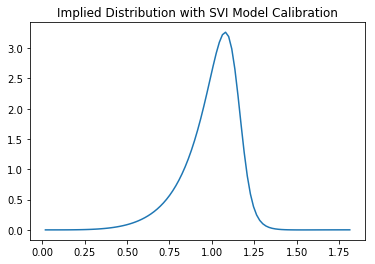

In [29]:
SVIprice_k_F = [SVI_Price(KK, 5460, T, r)*5460 for KK in np.arange(100, 10000, 100)]
plt.plot(np.arange(100, 10000, 100)/5460, SVIprice_k_F)
plt.title('Implied Distribution with SVI Model Calibration')
plt.legend()

### Problem 2(d)

In [30]:
def price(payoff, r, T=1, dist=SVI_Price, F=5460):
    x = np.arange(100, 10000, 50)
    SVIprice_k_F = [dist(KK, 5460, T, r) for KK in x]
    dP = np.array(SVIprice_k_F) * 50
    fx_T = np.array([payoff(ii) for ii in x])
    return np.exp(-r*T)*np.dot(fx_T, dP)

In [31]:
xi = lambda x: int(x >= 5448)
def conv(x, p=.5):
    _x = x / 5448
    if _x > .75:
        return max(1, 1+p*(_x-1))
    else:
        return _x
ret = lambda x: max(0, 1-5448/x)
log_pay = lambda x: -2*np.log(x/5448)

In [32]:
results = pd.DataFrame([[price(xi, r), price(conv, r), price(ret, r), price(log_pay, r)]], columns=['Digital Call', 'Reverse Convertible', 'Option Paying off Max', 'Log-Contract Paying off'], index=['Price'])
results

,Digital Call,Reverse Convertible,Option Paying off Max,Log-Contract Paying off
Price,0.58801,0.989291,0.053029,0.02806


Hence, we can conclude that the price of the Digital Call is similar to the price of the smile-adjusted formula;
Since the result of the Reverse Convertible is close to 1, it implies that it must have heavy left tail;
The option paying off Max shows that the average return is about 5%;
The log-contract paying off reveals that it's not log-normal, since it has a heavy left tail for its distribution.

### Problem 3

Find conditions on the SVI model parameters to satisfy Lee’s asymptotic bounds on p.22

The asymptotic bounds: 
$$ \sigma ^{*2}(k_F,T) \leq \frac{\beta}{T}|\text{ln}k_F|,  \beta \in [0,2]. $$ For each $\beta$:
For $k_F \rightarrow 0^+$,The bound: $$ \sigma ^{*2}(k_F,T) \leq \frac{\beta_1}{T}|\text{ln}k_F|,  \beta_1 \in [0,2].$$
For $k_F \rightarrow +\infty$,The bound: $$ \sigma ^{*2}(k_F,T) \leq \frac{\beta_2}{T}|\text{ln}k_F|,  \beta_2 \in [0,2].$$

The SVI model:
$$\sigma^*_{SVI}(k_F,T)= \sqrt{a+b[\rho(\text{ln}k_F-m)+\sqrt{(\text{ln}k_F-m)^2+s^2}]}$$
Square $\sigma^*_{SVI}(k_F,T)$ and plug into the above equations:
        
$$\text{lim}_{k_F\rightarrow 0^+}\frac{T\{a+b[\rho(\text{ln}k_F-m)+\sqrt{(\text{ln}k_F-m)^2+s^2}]\}}{|\text{ln}k_F|} \leq \beta_1$$ 

$$Tb(1-\rho)\leq \beta_1$$

$$\text{lim}_{k_F\rightarrow +\infty}\frac{T\{a+b[\rho(\text{ln}k_F-m)+\sqrt{(\text{ln}k_F-m)^2+s^2}]\}}{|\text{ln}k_F|} \leq \beta_2$$ 

$$Tb(1+\rho)\leq \beta_2$$

$\beta_i \in [0,2]$ for $i=1,2$,
$$0\leq b(1-\rho)T\leq 2,$$ $$0\leq b(1+\rho)T\leq 2.$$ 
$$0\leq b(1\pm \rho)\leq \frac{2}{T}$$

### Problem 4(a)


- Produce the graph of the local volatility surface for spots 0 to 200 and maturities 0 to 5 years


Consider an underlying stock S currently trading at $\ S_{0} = 100 $ which does not pay any dividend. Assume the local volatility function $ \sigma _{loc} (t,S) = 0.1 + \frac{0.1- 0.15 ln(S/S_{0})}{\sqrt{t}} $ and that interest rates are zero. 



#### Solution:
We consider maturities with every three month periods. Therefore the maturities are 0.25,0.5,0.75,1,1.25 etc upto 5 years
200 spots between 0 and 200 as 0,1,2, ..... 200


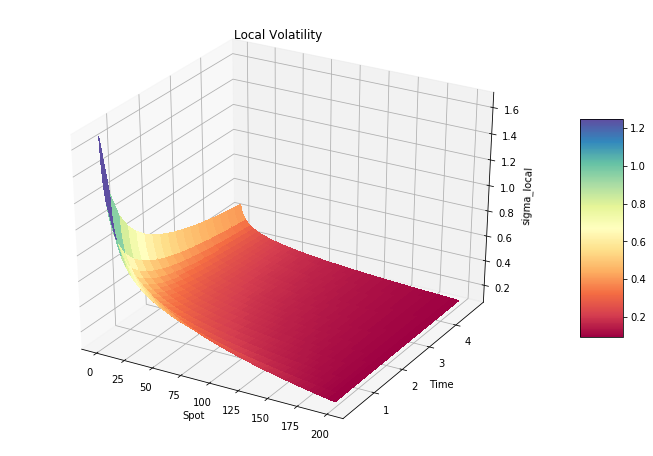

In [33]:

spot = np.arange(1,200,1)
time = np.arange(0.25,5,0.25)

def calc_loc_vol (s,t,s0):
    return (0.1 + ((0.1- 0.15 *(np.log(s/s0)))/np.sqrt(t)))

vol = np.zeros(shape=[len(spot), len(time)])

for i in range(len(spot)):
    for j in range(len(time)):
        vol[i, j] = calc_loc_vol(spot[i],time[j],100)
        

X, Y = np.meshgrid(spot, time)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
h = ax.plot_surface(X.T, Y.T, vol, cmap=cm.Spectral,linewidth=0, antialiased=False)
fig.colorbar(h, shrink=0.5, aspect=5)
plt.title('Local Volatility')
ax.set_xlabel('Spot')
ax.set_ylabel('Time')
ax.set_zlabel('sigma_local')
plt.show()


### problem 4(b)

- write a Monte-Carlo algorithm to price the following 1-year payoffs using 252 time-steps and e.g. 10000 paths 


(i) capped quadratic option = $  min (1, \frac {S_{1}^2}{S_{0}^2}) $

(ii) Asian-at-the-money call 

(iii) Barrier call

#### Solution:

Assume the stock price follows a geometric brownian motion then the stock price at any time t is given as 

$ S_{t}= S_{0} e^{(\mu -0.5\sigma ^2)t + \sigma_{loc} \sqrt{t} Z} $

Using the Euler-Maruyama discretization method provides 

$ S_{t + \Delta t} = S_{t}(1+ v_{t}\Delta t + \sigma_{loc}(t,S_{t}) \epsilon_{t} \sqrt\Delta t )$

where $ v_{t} $ is the risk-neutral drift (forward interest rate minus dividend rate)
In our case $ v_{t} $ is zero because diveidend rate is zero and interest rates are zero 

In [34]:
### Pricing a capped Quadratic option

delta_t = 1/252 

def stock_price_path(spot,num):
    s_path =[]
    s_path.append(spot)
    for i in range (1,num+1):
        t=i*delta_t
        vol=calc_loc_vol(s_path[i-1],t,spot)
        temp = s_path[i-1]*(1+ vol*np.sqrt(delta_t)*np.random.normal())
        s_path.append(temp)
    return s_path

def stock_payoff_quad (spot,num):
    stockprice = stock_price_path(spot,num)[-1]
    quad_payoff = (stockprice/spot)**2 
    payoff = min(1.0, quad_payoff)
    return payoff
  
def price_quad_option(number_simulation,spot,num):
    cumsum=0.0
    for i in range (0,number_simulation):
        cumsum = cumsum + stock_payoff_quad(spot,num)
    return cumsum/number_simulation

CQprice = price_quad_option(10000,100.0,252)
print("price of the capped quadratic option is", CQprice)


price of the capped quadratic option is 0.7914074116874815


In [35]:
### Pricing an Asian at the money call 

def stock_payoff_asian (spot,num):
    stockpricepath = stock_price_path(spot,num)
    temp = (0.25*(stockpricepath[63]+stockpricepath[126] + stockpricepath[189] +stockpricepath[252])/spot)-1
    payoff = max(0.0, temp)
    return payoff

def price_asian_option(number_simulation,spot,num):
    cumsum=0.0
    for i in range (0,number_simulation):
        cumsum = cumsum + stock_payoff_asian(spot,num)
    return cumsum/number_simulation

ACprice = price_asian_option(10000,100.0,252)
print("price of asian option is", ACprice)


price of asian option is 0.11502259314607323


In [36]:
### Pricing a Barrier Call

def stock_payoff_barrier(spot,num):
    stockpath = stock_price_path(spot,num)
    temp_greater=0.0
    temp_lower=0.0
    for i in range(len(stockpath)):
        if stockpath[i] > 80:
            temp_greater = temp_greater+1
        else :
            temp_lower = temp_lower+1
    if temp_greater == 252:
        return max(0,stockpath[-1]-spot)
    else:
        return 0

    
def price_barrier_option(number_simulation,spot,num):
    cumsum=0.0
    for i in range(0,number_simulation):
        cumsum = cumsum + stock_payoff_barrier(spot,num)
    return cumsum/number_simulation

BCprice = price_barrier_option(10000,100.0,252)
print("price of Barrier call option is", BCprice)

price of Barrier call option is 0.2564751658524568


In [37]:
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print('The estimated price of “Capped quadratic” option is', CQprice)
print('The estimated price of Asian at-the-money- call option is', ACprice)
print('The estimated price of Barrier Call Price', BCprice)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
The estimated price of “Capped quadratic” option is 0.7914074116874815
The estimated price of Asian at-the-money- call option is 0.11502259314607323
The estimated price of Barrier Call Price 0.2564751658524568
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


### Problem 5(a)

The payoff of a 1-year at-the-money call on the geometric average return of two non-dividendpaying
stocks X, Y is given as:

$$ f(X_T, Y_T) = \max ( 0,\sqrt{\frac{X_T Y_T}{X_0 Y_0}}-1 )$$
where $T=1$ year and $X_t,Y_t$ are the respective underlying spot prices of $X,Y$ at any time $t$.

(a) Derive analytical formulas for the call value at any time 0 ≤ 𝑡 ≤ 𝑇 in the Black-Scholes model with
constant correlation 𝜌 (cf. Section 6-4 in the textbook, to be covered during Session 5.)

- Derivation:


Assume $X,Y$ follow correlated Geometric Brownian processes:
$$ dX_t = \mu_1 X_t dt + \sigma_1 X_t dW_t^{(1)} $$
$$ dY_t = \mu_2 Y_t dt + \sigma_2 Y_t dW_t^{(2)} $$
$$ dW_t^{(1)}dW_t^{(2)} = \rho dt $$

the risk-free rates is $r$ is constant

Using Ito's lemma:

$Z_t = X_tY_t$, b
$$ dZ_t =  X_t dY_t + Y_t dX_t + dY_t dX_t $$
$$ dZ_t =  (2r + \rho \sigma_1 \sigma_2)Z_tdt + \sigma_1 Z_tdW_t^{(1)} + \sigma_2Z_t dW_t^{(2)} $$

$\sigma_1 dW_t^{(1)} + \sigma_2 dW_t^{(2)} = \sqrt{\sigma_1^2 + 2\rho\sigma_1\sigma_2 + \sigma_2^2} dW_t^{(3)} $, where $W_t^{(i)}, i=1,2,3$ is Standard Brownian Motion.

$$ dZ_t =  (2r + \rho \sigma_1 \sigma_2)Z_tdt + \sqrt{\sigma_1^2 + 2\rho\sigma_1\sigma_2 + \sigma_2^2} Z_t dW_t^{(3)} $$

$U_t = \sqrt{Z_t}$
$$ dU_t = \frac{1}{2\sqrt{Z_t}} dZ_t + \frac{1}{2} (-\frac{1}{4}) \frac{1}{Z_t\sqrt{Z_t}} (dZ_t)^2$$
$$ dU_t = (r - \frac{1}{8}\sigma_1^2 - \frac{1}{8}\sigma_2^2 + \frac{1}{4}\rho\sigma_1\sigma_2) U_t dt + \frac{1}{2} \sqrt{\sigma_1^2 + 2\rho\sigma_1\sigma_2 + \sigma_2^2} U_t dW_t^{(3)} $$


$$ d(ln(U_t)) = (r - \frac{1}{4}\sigma_1^2 - \frac{1}{4}\sigma_2^2 ) dt + \frac{1}{2} \sqrt{\sigma_1^2 + 2\rho\sigma_1\sigma_2 + \sigma_2^2} dW_t^{(3)} $$

Therefore, plugging everything into B-S formula

$$S = \sqrt{\frac{X_tY_t}{X_0Y_0}}, K=1, r^*=(r - \frac{1}{8}\sigma_1^2 - \frac{1}{8}\sigma_2^2 + \frac{1}{4}\rho\sigma_1\sigma_2), \sigma^* = \frac{1}{2} \sqrt{\sigma_1^2 + 2\rho\sigma_1\sigma_2 + \sigma_2^2}$$

The analytical formulas for the call value at any time $0\leq t\leq T$ is obtained as follows:
$$C(t) = \sqrt{\frac{X_tY_t}{X_0Y_0}}e^{(r^*-r)(T-t)}N(d_1) - e^{-r(T-t)}N(d_2) = \sqrt{\frac{X_tY_t}{X_0Y_0}}e^{-( \frac{1}{8}\sigma_1^2 + \frac{1}{8}\sigma_2^2 - \frac{1}{4}\rho\sigma_1\sigma_2)\tau}N(d_1) - e^{-r\tau}N(d_2)$$
$$d_1 = \frac{\ln(\sqrt{\frac{X_tY_t}{X_0Y_0}}) + (r+\frac{1}{2}\rho\sigma_1\sigma_2) (T-t)}{\frac{1}{2} \sqrt{\sigma_1^2 + 2\rho\sigma_1\sigma_2 + \sigma_2^2} \sqrt{T-t}}$$
$$d_2 = d_1 - \sigma^* \sqrt{T-t} = \frac{\ln(\sqrt{\frac{X_tY_t}{X_0Y_0}}) + (r-\frac{1}{4}\sigma_1^2-\frac{1}{4}\sigma_2^2) (T-t)}{\frac{1}{2} \sqrt{\sigma_1^2 + 2\rho\sigma_1\sigma_2 + \sigma_2^2} \sqrt{T-t}}$$

### Problem 5(b)

Compute the value of the call using a 5% interest rate, 20% volatility for X, 30% volatility for Y, and
𝜌 = 0.4. Use finite differences to estimate the deltas, gammas and cross-gamma of the call.


To answer the question, where we have an ATM option with underlying at $X_0 = 1, Y_0 = 1$. So $\sigma_1 = 0.2, \sigma_2 = 0.3, r = 0.05$, one year to maturity and we can generate the stock path.

In [38]:
# Generate stock paths as Geometric Brownian Motions 
# Note that We can use the Cholesky decomposition of the correlation matrix 
# to generate correlated Brownian motions from uncorrelated ones
def get_GBM_path(T,dt,rho,Sx,Sy,rx,ry,qx,qy,sigmax,sigmay):
    ''' 
    Parameters: 
    T: time to maturity
    dt: time increment
    rho: correlation
    Sx: price for an underlying asset_stock X
    Sy: price for for an underlying asset_stock Y
    rx: interest rate for stock X
    ry: interest rate for stock Y
    qx: dividend rate for stock X
    qy: dividend rate for stock Y
    sigmax: sigma(volatility) for stock X
    sigmay: sigma(volatility) for stock Y
  
    '''
    _steps = np.arange(0,T+dt,dt)
    _SxPath = [Sx]
    _SyPath = [Sy]
    _numSteps = len(_steps)
    # Z = rho*W+rho_bar*W_ortho
    #rho_bar is the orthogonal component of rho   
    dWx = np.random.normal(0, np.sqrt(dt), _numSteps)
    dWy = rho * dWx + np.sqrt(1 - rho **2) * np.random.normal(0, np.sqrt(dt), _numSteps)
    for k in range(1,len(_steps)):
        _SxPath.append(_SxPath[k-1]*np.exp((rx-qx-0.5*(sigmax**2))*dt+sigmax*np.sqrt(dt)*dWx[k]))
        _SyPath.append(_SyPath[k-1]*np.exp((ry-qy-0.5*(sigmay**2))*dt+sigmay*np.sqrt(dt)*dWy[k]))
    return _SxPath,_SyPath


In [39]:
Sx=1
Sy =1
sigmax=.2
sigmay =.3
rx =.05
ry= .05
qx=0
qy=0
T = 1
M=252 # trading days
dt= float(T) / M
rho = 0.4
_SxPath,_SyPath=get_GBM_path(T,dt,rho,Sx,Sy,rx,ry,qx,qy,sigmax,sigmay)

Text(0.5,1,'Generated GBM paths')

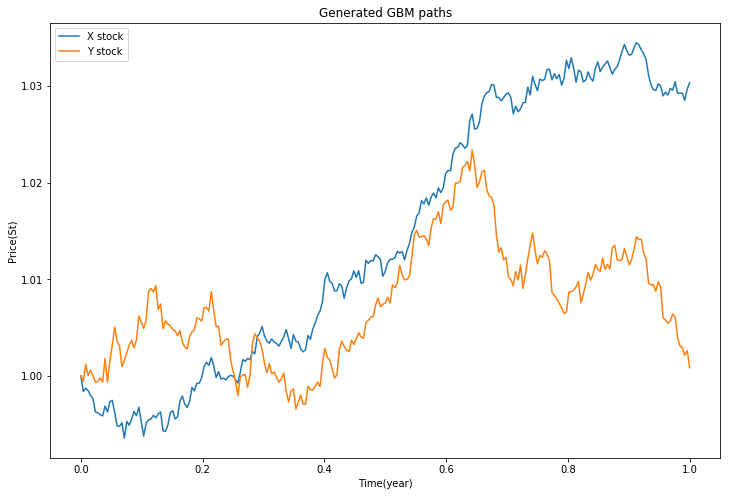

In [40]:
plt.figure(figsize=[12, 8])
plt.plot(np.arange(0,1+dt,dt),_SxPath)
plt.plot(np.arange(0,1+dt,dt),_SyPath)
tags=['X stock', 'Y stock']
plt.legend(tags, loc='best')
plt.xlabel("Time(year)")
plt.ylabel("Price(St)")
plt.title("Generated GBM paths")

In [41]:
def BS_EuroCall_Pricer(S,K,sigma,r,q,T):
    discount_factor = np.exp(-q * T)
    d1 = (np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    callPayoff= 0
    callPayoff = S* discount_factor*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
 
    return callPayoff

In [42]:
_callPayoff = []
M=252 # trading days

for i in range(M):
    S0 = np.sqrt((_SxPath[i]*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    r = 0.05
    q = 1./8*(sigmax**2 + sigmay**2 - 2*rho*sigmax*sigmay)
    K = 1
    T=(1-i/M)
    
    implied_Vol = 0.5 * np.sqrt(sigmax**2 + sigmay**2 + 2*rho*sigmax*sigmay)
    call = BS_EuroCall_Pricer(S0,K,implied_Vol,r,q,T)
    _callPayoff.append(call)

In [43]:
print("The call price is:")
_callPayoff

The call price is:


[0.10224844723421089,
 0.10135161382268365,
 0.10173982713601026,
 0.10108795801475035,
 0.10086692115555629,
 0.10036015032096735,
 0.09950319931475571,
 0.09926003607141232,
 0.0990732013653759,
 0.09867423646089968,
 0.09948382090194641,
 0.09831212245693366,
 0.09906260731370453,
 0.09936292354779597,
 0.09931142096222567,
 0.09818853417419926,
 0.09780275205318678,
 0.09703066102771118,
 0.09650601544325033,
 0.09702863529477412,
 0.09689943831998271,
 0.0970050849162718,
 0.09676319883227169,
 0.09662993889343463,
 0.09740230530040672,
 0.09649640806165805,
 0.09562197886098323,
 0.09603081792174617,
 0.09679026203387908,
 0.09666677342471763,
 0.09643248784615888,
 0.0963021509104699,
 0.09543324580849855,
 0.09542020472928492,
 0.09380998382484773,
 0.09378357312820185,
 0.09363651582404964,
 0.09372749550290438,
 0.09342178624554431,
 0.09287636197340732,
 0.09253328080436796,
 0.09293322514863822,
 0.09248663263194812,
 0.09183549426090432,
 0.09140667804145808,
 0.0917302704

Text(0.5,1,'Call')

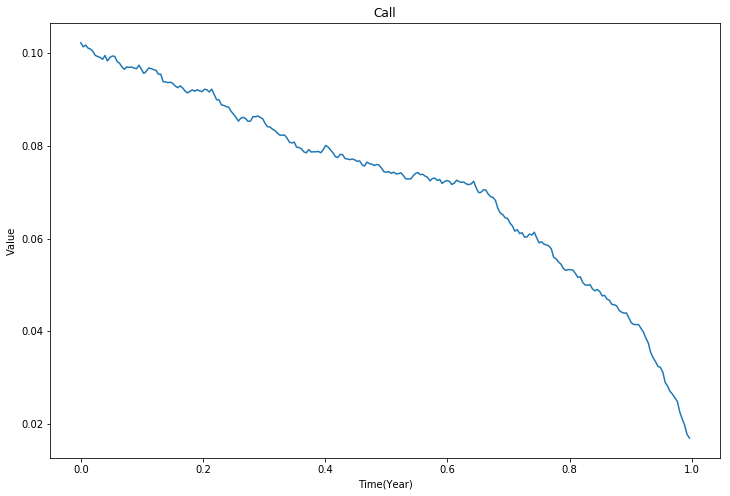

In [44]:
plt.figure(figsize=[12, 8])
plt.plot(np.arange(0,1,dt),_callPayoff)
plt.xlabel("Time(Year)")
plt.ylabel("Value")
plt.title("Call")

### Deltas estimation using finite differences: 

In [45]:
T = 1
M=252 # trading days
dt= float(T) / M
deltaX = []
deltaY = []
deltat =1/10e3
for i in range(M):
    r = 0.05 
    K= 1
    T = (1-i/M)
    q = 1./8 * (sigmax**2 + sigmay**2 - 2*rho*sigmax*sigmay)
    implied_Vol = 0.5 * np.sqrt(sigmax**2 + sigmay**2 + 2*rho*sigmax*sigmay)
    _mS0dlt = np.sqrt((_SxPath[i]*(1-deltat)*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    _mCall = BS_EuroCall_Pricer(_mS0dlt,K,implied_Vol,r,q,T)
   
    _pS0dlt = np.sqrt((_SxPath[i]*(1+deltat)*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    _pCall = BS_EuroCall_Pricer(_pS0dlt,K,implied_Vol,r,q,T)
    deltaX.append((_pCall-_mCall)/(2*_SxPath[i]*deltat))
    deltaY.append((_pCall-_mCall)/(2*_SyPath[i]*deltat))
    

In [46]:
print("DeltaX:")
print(deltaX)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("DeltaY:")
print(deltaY)

DeltaX:
[0.3046542184637069, 0.30373646816082767, 0.30477177177891457, 0.30392024221816577, 0.30399899132163355, 0.30346240528484075, 0.3025231043194915, 0.3024304775910335, 0.3024890860876376, 0.30209257632337533, 0.3037983426567367, 0.3019892451988488, 0.30357030092358794, 0.30451700950719646, 0.30518078912176, 0.3037083118647922, 0.3033125925196451, 0.30200310091319277, 0.30178629518637334, 0.3027317099685325, 0.30298053905031974, 0.30340380215884183, 0.3030556889787341, 0.30331291314059716, 0.30504411045703456, 0.30403676836306465, 0.30306105590049925, 0.3039150184294393, 0.30579570161364367, 0.3059237989868895, 0.3057304612111862, 0.3059513700316736, 0.30442336728563124, 0.3047462940730512, 0.30236041979474604, 0.30273962468331594, 0.30265193840030374, 0.30287705110181634, 0.3025831342340349, 0.3021013110483371, 0.3017318543963688, 0.30252973654067655, 0.3018366771135708, 0.3011184518132161, 0.3007358241049983, 0.30168373285286737, 0.3024074448717561, 0.3023142299155264, 0.3032744

Text(0,0.5,'Delta evolution')

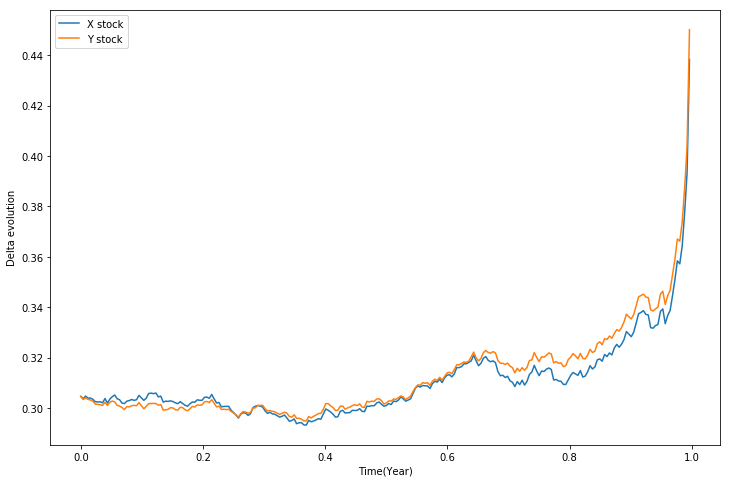

In [47]:
plt.figure(figsize=[12, 8])
plt.plot(np.arange(0,1,dt),deltaX)
plt.plot(np.arange(0,1,dt),deltaY)
tags=['X stock', 'Y stock']
plt.legend(tags, loc='best')
plt.xlabel("Time(Year)")
plt.ylabel("Delta evolution")

### Gammas estimation using finite differences:


In [48]:
T = 1
M=252 # trading days
dt= float(T) / M
_gammaX = []
_gammaY = []
deltat = 1/10e3
for i in range(M):
    r = 0.05
    q = 1./8 * (sigmax**2 + sigmay**2 - 2*rho*sigmax*sigmay)
    K = 1
    T=(1-i/M)
    implied_Vol = 0.5 * np.sqrt(sigmax**2 + sigmay**2 + 2*rho*sigmax*sigmay)
    S0 = np.sqrt((_SxPath[i]*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    _call = BS_EuroCall_Pricer(S0,K,implied_Vol,r,q,T)
    _pS0dlt = np.sqrt((_SxPath[i]*(1+deltat)*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    _pCall = BS_EuroCall_Pricer(_pS0dlt,K,implied_Vol,r,q,T)
    _mS0dlt = np.sqrt((_SxPath[i]*(1-deltat)*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    _mCall = BS_EuroCall_Pricer(_mS0dlt,K,implied_Vol,r,q,T)
    
    _gammaX.append((_pCall-2*_call+_mCall)/(_SxPath[i]*deltat*_SxPath[i]*deltat))
    _gammaY.append((_pCall-2*_call+_mCall)/(_SyPath[i]*deltat*_SyPath[i]*deltat))


In [49]:
print("GammaX:")
print(_gammaX)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("GammaY:")
print(_gammaY)

GammaX:
[0.29586162408890004, 0.2987046343575917, 0.298759165016791, 0.30049363501345255, 0.3018329315921902, 0.30345825741163035, 0.30615335577850006, 0.30729817079054284, 0.30845239684081616, 0.30983220727215127, 0.30894930070260984, 0.31165024600213925, 0.31081856730979496, 0.31113786313459757, 0.3127983114045059, 0.3159890769477808, 0.31734145192138374, 0.31895994025138363, 0.3215067006246942, 0.3205523395110823, 0.32183563307685464, 0.3221467510206412, 0.32280974246429367, 0.324141275402058, 0.32338910028425744, 0.3264930127076291, 0.3295270278986354, 0.328979967979624, 0.3285816477912691, 0.3295890078407169, 0.3305593597432187, 0.3318144560366774, 0.33367644270646707, 0.3344665706439241, 0.33897593518973324, 0.3399944521647756, 0.34070992332952516, 0.34065499208977196, 0.3418910059401216, 0.3442105930286325, 0.3455300431583629, 0.34482527742274544, 0.34606096042280904, 0.3485551688940203, 0.35042321894635997, 0.3505323747696992, 0.3500355198010145, 0.35173555981021354, 0.35169784

Text(0.5,1,'Gamma evolution')

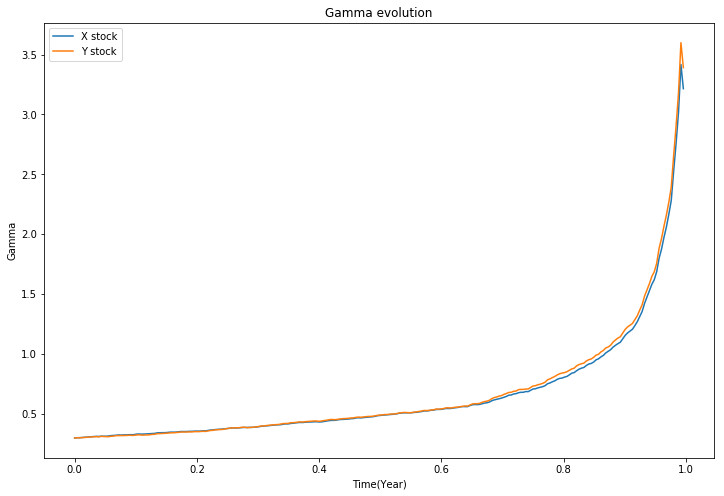

In [50]:
plt.figure(figsize=[12, 8])
plt.plot(np.arange(0,1,dt),_gammaX)
plt.plot(np.arange(0,1,dt),_gammaY)
tags=['X stock', 'Y stock']
plt.legend(tags, loc='best')
plt.xlabel("Time(Year)")
plt.ylabel("Gamma")
plt.title("Gamma evolution")

### Cross Gammas estimation using finite differences

In [51]:
T = 1
M=252 # trading days
dt= float(T) / M
deltat =1/10e3
_cross_gamma = []

for i in range(M):
    r = 0.05
    q = 1./8 * (sigmax**2 + sigmay**2 - 2*rho*sigmax*sigmay)
    K = 1
    T=(1-i/M)
    implied_Vol = 0.5 * np.sqrt(sigmax**2 + sigmay**2 + 2*rho*sigmax*sigmay)
    S0 = np.sqrt((_SxPath[i]*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    _call = BS_EuroCall_Pricer(S0,K,implied_Vol,r,q,T)
    _pS0dlt = np.sqrt((_SxPath[i]*(1+deltat)*_SyPath[i])/(_SxPath[0]*_SyPath[0]))
    _pCall = BS_EuroCall_Pricer(_pS0dlt,K,implied_Vol,r,q,T)
    _mS0dlt = np.sqrt((_SxPath[i]*(1+deltat)*_SyPath[i])*(1+deltat)/(_SxPath[0]*_SyPath[0]))
    _mCall = BS_EuroCall_Pricer(_mS0dlt,K,implied_Vol,r,q,T)
    _cross_gamma.append(( _mCall-2*_pCall+_call)/(_SxPath[i]*deltat*_SyPath[i]*deltat))


In [52]:
print("Cross Gama:")
print(_cross_gamma)

Cross Gama:
[0.6004770125578318, 0.6022584329006191, 0.6024096070964124, 0.6038924290453327, 0.604830353758638, 0.6061391157149967, 0.6078987110546481, 0.6088833417562907, 0.6098017079194167, 0.6109960517582412, 0.6106439345007155, 0.6128460748449086, 0.6125743916462615, 0.6128790725754595, 0.6136469221817247, 0.6158295679537185, 0.6170505015926403, 0.6187814120838689, 0.6201955508256137, 0.6202499546109199, 0.6211592335308297, 0.6217623797582884, 0.6228315687565273, 0.6237620615984295, 0.6234749598665564, 0.6254607891870163, 0.6274066224168443, 0.62763084788157, 0.6273668415115915, 0.6283139888460311, 0.6294209018232657, 0.6303899488402068, 0.6323937578369039, 0.6332158564113057, 0.6362547501251872, 0.6371176964556072, 0.6381524274766353, 0.6388629726931615, 0.6401313408755909, 0.6417418897898775, 0.6430789819527896, 0.6433824972668383, 0.6448814650889887, 0.6466767411625582, 0.6481678240615175, 0.6486057315623339, 0.6490224153432919, 0.6503531320823258, 0.6507552595944088, 0.65207875

Text(0.5,1,'Cross-Gamma evolution')

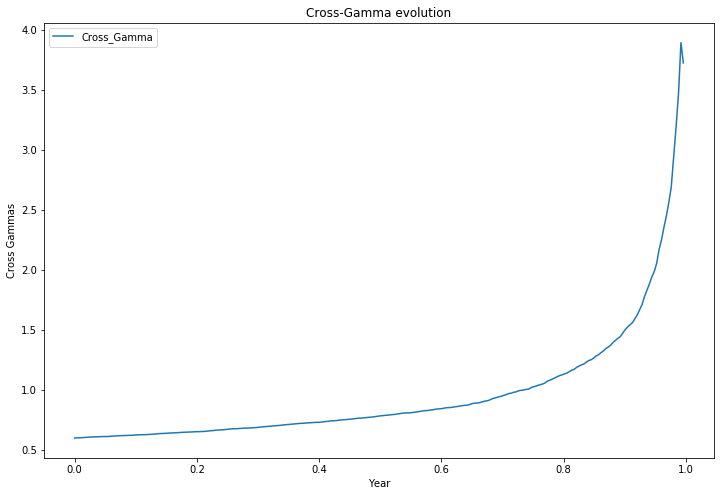

In [53]:
plt.figure(figsize=[12, 8])
plt.plot(np.arange(0,1,dt),_cross_gamma)
tags=['Cross_Gamma']
plt.legend(tags, loc='best')
plt.xlabel("Year")
plt.ylabel("Cross Gammas")
plt.title("Cross-Gamma evolution")

### Problem 5(c)

You purchased the call on a $10,000,000 notional. What actions would you take to delta-hedge your
position? What would then be your instant P&L in the following matrix of scenarios:

Generally, graph your instant P&L against percent changes 𝑥, 𝑦 in underlying stock prices.

Hegding x and y amount of $X$ and $Y$ shares, respectively, by selling $X$, and $Y$ stocks as follows:

In [54]:
# P&L
pnl=[]
N=10000000
deltaX[0]*N 
deltaY[0]*N
dltX = [-0.05,-0.01,0.05]
dltY = [-0.05,0.01,0.05]
r = 0.05
q = 1./8 * (sigmax**2 + sigmay**2 - 2*rho*sigmax*sigmay)
K = 1
T = 1
t = 0
implied_Vol = 0.5 * np.sqrt(sigmax**2 + sigmay**2 + 2*rho*sigmax*sigmay)
S0 = np.sqrt((_SxPath[t]*_SyPath[t])/(_SxPath[0]*_SyPath[0]))
_call = BS_EuroCall_Pricer(S0,K,implied_Vol,r,q,T)

for i in dltX:
    _ls = []
    for k in dltY:
        S0_delta = np.sqrt((_SxPath[t]*(1+i)*_SyPath[t]*(1+k))/(_SxPath[0]*_SyPath[0]))
        _deltax = deltaX[0]
        _deltay = deltaY[0]
        _option_pnl = BS_EuroCall_Pricer(S0_delta,K,implied_Vol ,r,q,T) - _call
        _stock_pnl = - _deltax * i * _SxPath[0] - _deltay * k * _SyPath[0]
        _total_cum_pnl = (_option_pnl + _stock_pnl)*N
        _ls.append(_total_cum_pnl)
        
    pnl.append(_ls)
pnl_df = pd.DataFrame(pnl,index=dltX,columns=dltY)
print(" our instant PnL in the following matrixof scenarios:")
pnl_df

 our instant PnL in the following matrixof scenarios:


,-0.05,0.01,0.05
-0.05,23227.222378,1012.836124,-7607.084285
-0.01,7109.670422,-304.639425,685.340384
0.05,-7607.084285,6582.922745,21457.441028


Graphing our instant P&L against percent changes $X$, $Y$ in underlying stock prices.

In [55]:

pnl=[]
dltX = np.array([0.001 * i for i in range(-100, 101, 2)])+0.0005
dltY = np.array([0.001 * i for i in range(-100, 101, 2)])+0.0005

r = 0.05
q = 1./8 * (sigmax**2 + sigmay**2 - 2*rho*sigmax*sigmay)
K = 1
T = 1
t = 0
implied_Vol = 0.5 * np.sqrt(sigmax**2 + sigmay**2 + 2*rho*sigmax*sigmay)
S0 = np.sqrt((_SxPath[t]*_SyPath[t])/(_SxPath[0]*_SyPath[0]))
_call = BS_EuroCall_Pricer(S0,K,implied_Vol,r,q,T)

for i in dltX:
    _ls = []
    for k in dltY:
        S0_delta = np.sqrt((_SxPath[t]*(1+i)*_SyPath[t]*(1+k))/(_SxPath[0]*_SyPath[0]))
        _deltax = deltaX[0]
        _deltay = deltaY[0]
        _option_pnl = BS_EuroCall_Pricer(S0_delta,K,implied_Vol ,r,q,T) - _call
        _stock_pnl = - _deltax * i * _SxPath[0] - _deltay * k * _SyPath[0]
        _total_cum_pnl = (_option_pnl + _stock_pnl)*N
        _ls.append(_total_cum_pnl)
        
    pnl.append(_ls)
pnl_df = pd.DataFrame(pnl,index=dltX,columns=dltY)
print(" our instant PnL in the following matrix of scenarios:")
pnl_df

 our instant PnL in the following matrix of scenarios:


,-0.0995,-0.0975,-0.0955,-0.0935,-0.0915,-0.0895,-0.0875,-0.0855,-0.0835,-0.0815,...,0.0825,0.0845,0.08650000000000001,0.0885,0.0905,0.0925,0.0945,0.0965,0.0985,0.1005
-0.0995,94455.612731,92523.610410,90607.306043,88706.645901,86821.576001,84952.042110,83097.989753,81259.364217,79436.110559,77628.173608,...,-24041.883938,-24782.934527,-25513.635175,-26234.044454,-26944.220844,-27644.222725,-28334.108383,-29013.936001,-29683.763659,-30343.649335
-0.0975,92523.610410,90616.600054,88725.303371,86849.666017,84989.633395,83145.150666,81316.162747,79502.614327,77704.449862,75921.613588,...,-23699.976111,-24416.666167,-25123.031099,-25819.129757,-26505.020893,-27180.763159,-27846.415105,-28502.035177,-29147.681717,-29783.412959
-0.0955,90607.306043,88725.303371,86859.029509,85008.429496,83173.448126,81354.029951,79550.119284,77761.660214,75988.596600,74230.872086,...,-23343.129024,-24035.488408,-24717.547876,-25389.366548,-26051.003448,-26702.517495,-27343.967502,-27975.412176,-28596.910117,-29208.519811
-0.0935,88706.645901,86849.666017,85008.429496,83182.880766,81372.964007,79578.623165,77799.801954,76036.443858,74288.492145,72555.889865,...,-22971.444377,-23639.503350,-24297.287997,-24944.857711,-25582.271780,-26209.589390,-26826.869613,-27434.171416,-28031.553650,-28619.075054
-0.0915,86821.576001,84989.633395,83173.448126,81372.964007,79588.124610,77818.873275,76065.153113,74326.907012,72604.077643,70896.607468,...,-22585.023670,-23228.812886,-23862.353746,-24485.705913,-25098.928941,-25702.082274,-26295.225244,-26878.417073,-27451.716863,-28015.183601
-0.0895,84952.042110,83145.150666,81354.029951,79578.623165,77818.873275,76074.723015,74346.114893,72632.991203,70935.294023,69252.965224,...,-22183.968201,-22803.518698,-23412.847190,-24012.013603,-24601.077753,-25180.099344,-25749.137962,-26308.253081,-26857.504052,-27396.950108
-0.0875,83097.989753,81316.162747,79550.119284,77799.801954,76065.153113,74346.114893,72642.629206,70954.637746,69282.082000,67624.903253,...,-21768.379057,-22363.722257,-22948.870176,-23523.883002,-24088.820810,-24643.743560,-25188.711091,-25723.783125,-26249.019260,-26764.478970
-0.0855,81259.364217,79502.614327,77761.660214,76036.443858,74326.907012,72632.991203,70954.637746,69291.787740,67644.382082,66012.361470,...,-21338.357113,-21909.524813,-22470.524325,-23021.416099,-23562.260467,-24093.117639,-24614.047707,-25125.110636,-25626.366269,-26117.874320
-0.0835,79436.110559,77704.449862,75988.596600,74288.492145,72604.077643,70935.294023,69282.082000,67644.382082,66022.134577,64415.279596,...,-20894.003025,-21441.027389,-21977.911030,-22504.714651,-23021.498839,-23528.324054,-24025.250634,-24512.338789,-24989.648600,-25457.240019
-0.0815,77628.173608,75921.613588,74230.872086,72555.889865,70896.607468,69252.965224,67624.903253,66012.361470,64415.279596,62833.597158,...,-20435.417226,-20958.330785,-21471.131448,-21973.880173,-22466.637795,-22949.465024,-23422.422440,-23885.570494,-24338.969504,-24782.679657


Graphing our instant P&L against percent changes $X$, $Y$ in underlying stock prices.

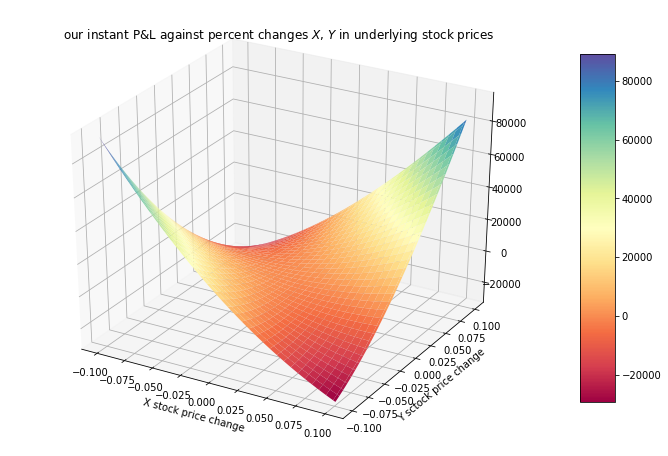

In [56]:
# 3D plotting
deltaX = np.array([0.001 * i for i in range(-100, 101, 2)])+0.0005
deltaY = np.array([0.001 * i for i in range(-100, 101, 2)])+0.0005
deltaX, deltaY= np.meshgrid(deltaX, deltaY)
figr = plt.figure(figsize=(12,8))
ax = figr.add_subplot(111, projection='3d')
surfce = ax.plot_surface(deltaX, deltaY, np.array(pnl), cmap=cm.Spectral)
figr.colorbar(surfce, shrink=0.8, aspect=10)
ax.set_xlabel('X stock price change')
ax.set_ylabel('Y sctock price change')
plt.title('our instant P&L against percent changes $X$, $Y$ in underlying stock prices')
plt.show()
